# Use Alabama 2016 Election Results To Estimate Partisan Votes By Race

Data sources:
 - County-level 2016 presidential election results: https://en.wikipedia.org/wiki/United_States_presidential_election_in_Alabama,_2016
 - County-level demographics: https://www.indexmundi.com/facts/united-states/quick-facts/alabama/black-population-percentage#table

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [2]:
# Data:
county = {
	'Autauga':{'black':18.4, 'trump':18110, 'clinton':5908},
	'Baldwin':{'black':9.5, 'trump':72780, 'clinton':18409},
	'Barbour':{'black':47.6, 'trump':5431, 'clinton':4848},
	'Bibb':{'black':22.1, 'trump':6733, 'clinton':1874},
	'Blount':{'black':1.8, 'trump':22808, 'clinton':2150},
	'Bullock':{'black':69.9, 'trump':1139, 'clinton':3530},
	'Butler':{'black':43.6, 'trump':4891, 'clinton':3716},
	'Calhoun':{'black':20.9, 'trump':32803, 'clinton':13197},
	'Chambers':{'black':39.1, 'trump':7803, 'clinton':5763},
	'Cherokee':{'black':4.5, 'trump':8937, 'clinton':1545},
	'Chilton':{'black':10.3, 'trump':15068, 'clinton':2909},
	'Choctaw':{'black':42.7, 'trump':4102, 'clinton':3109},
	'Clarke':{'black':44.2, 'trump':7109, 'clinton':5712},
	'Clay':{'black':14.4, 'trump':5230, 'clinton':1234},
	'Cleburne':{'black':3.6, 'trump':5738, 'clinton':684},
	'Coffee':{'black':17.5, 'trump':15825, 'clinton':4194},
	'Colbert':{'black':16.4, 'trump':16718, 'clinton':7296},
	'Conecuh':{'black':46.0, 'trump':3413, 'clinton':3069},
	'Coosa':{'black':31.3, 'trump':3376, 'clinton':1780},
	'Covington':{'black':12.7, 'trump':13222, 'clinton':2379},
	'Crenshaw':{'black':24.1, 'trump':4511, 'clinton':1663},
	'Cullman':{'black':1.4, 'trump':32734, 'clinton':3730},
	'Dale':{'black':19.6, 'trump':13789, 'clinton':4408},
	'Dallas':{'black':69.6, 'trump':5784, 'clinton':12826},
	'DeKalb':{'black':2.0, 'trump':21779, 'clinton':3682},
	'Elmore':{'black':21.1, 'trump':27619, 'clinton':8436},
	'Escambia':{'black':32.2, 'trump':10282, 'clinton':4698},
	'Etowah':{'black':15.5, 'trump':32132, 'clinton':10350},
	'Fayette':{'black':11.8, 'trump':6705, 'clinton':1358},
	'Franklin':{'black':4.3, 'trump':9466, 'clinton':2197},
	'Geneva':{'black':9.8, 'trump':9967, 'clinton':1522},
	'Greene':{'black':80.2, 'trump':838, 'clinton':4006},
	'Hale':{'black':57.9, 'trump':3172, 'clinton':4772},
	'Henry':{'black':27.5, 'trump':5623, 'clinton':2286},
	'Houston':{'black':26.4, 'trump':30567, 'clinton':10547},
	'Jackson':{'black':3.4, 'trump':16643, 'clinton':3663},
	'Jefferson':{'black':42.8, 'trump':134398, 'clinton':156384},
	'Lamar':{'black':11.4, 'trump':5819, 'clinton':1035},
	'Lauderdale':{'black':10.2, 'trump':27735, 'clinton':9877},
	'Lawrence':{'black':11.4, 'trump':10732, 'clinton':3611},
	'Lee':{'black':23.5, 'trump':34321, 'clinton':20987},
	'Limestone':{'black':13.2, 'trump':28824, 'clinton':9340},
	'Lowndes':{'black':73.1, 'trump':1751, 'clinton':4882},
	'Macon':{'black':81.5, 'trump':1394, 'clinton':7237},
	'Madison':{'black':24.5, 'trump':89199, 'clinton':62435},
	'Marengo':{'black':51.1, 'trump':5224, 'clinton':5607},
	'Marion':{'black':4.2, 'trump':11273, 'clinton':1432},
	'Marshall':{'black':2.3, 'trump':29217, 'clinton':4913},
	'Mobile':{'black':35.3, 'trump':94002, 'clinton':71001},
	'Monroe':{'black':41.3, 'trump':5771, 'clinton':4310},
	'Montgomery':{'black':56.3, 'trump':33928, 'clinton':58669},
	'Morgan':{'black':12.4, 'trump':37392, 'clinton':11216},
	'Perry':{'black':67.6, 'trump':1403, 'clinton':3823},
	'Pickens':{'black':40.9, 'trump':5454, 'clinton':3972},
	'Pike':{'black':36.7, 'trump':7681, 'clinton':5039},
	'Randolph':{'black':20.1, 'trump':7697, 'clinton':2290},
	'Russell':{'black':42.3, 'trump':9210, 'clinton':9577},
	'Shelby':{'black':11.8, 'trump':72846, 'clinton':22927},
	'St. Clair':{'black':9.3, 'trump':31579, 'clinton':5550},
	'Sumter':{'black':73.5, 'trump':1581, 'clinton':4739},
	'Talladega':{'black':32.3, 'trump':20596, 'clinton':12108},
	'Tallapoosa':{'black':27.1, 'trump':13546, 'clinton':5495},
	'Tuscaloosa':{'black':30.7, 'trump':47701, 'clinton':31746},
	'Walker':{'black':6.2, 'trump':24208, 'clinton':4486},
	'Washington':{'black':24.5, 'trump':6031, 'clinton':2366},
	'Wilcox':{'black':71.2, 'trump':1737, 'clinton':4329},
	'Winston':{'black':0.9, 'trump':9225, 'clinton':871}
}

ncounty = len(county)

In [3]:
# Collate Clinton percentage, black population percentage, and population
Cpct = []
Bpct = []
Pop = []
for cname in county:
    c = county[cname]
    Bpct.append(c['black']/100.0)
    totvote = float(c['trump'] + c['clinton'])
    Pop.append(totvote)
    Cpct.append(c['clinton']/totvote)
Cpct = np.array(Cpct)*100
Bpct = np.array(Bpct)
Pop = np.array(Pop)

## Linear regression:

Assume that in each county, white voters are split between $W_C$ who vote for Clinton and $W_T$ who vote for Trump, while black voters are split between $B_C$ who vote for Clinton and $B_T$ who vote for Trump. If the fraction of black voters is $b$, then the percentage of Clinton voters is:

$$ C = b B_C + (1-b) W_C $$
$$ C = b (B_C - W_C) + W_C $$

So if we do a linear regression of $C$ versus $b$, the intercept will be $W_C$ and the slope will be $B_C - W_C$.

In [4]:
import numpy as np
from scipy.stats import linregress
slope, intercept, rval, pval, stderr = linregress(Bpct, Cpct)
WC = intercept
BC = slope + WC
print 'White voters who voted for Clinton: %.1f%%' % WC
print 'Black voters who voted for Clinton: %.1f%%' % BC

White voters who voted for Clinton: 9.1%
Black voters who voted for Clinton: 97.5%


By this measure, white voters preferred Trump 91-9, while black voters preferred Clinton 97.5-2.5!!

But is the linear regression a good model?

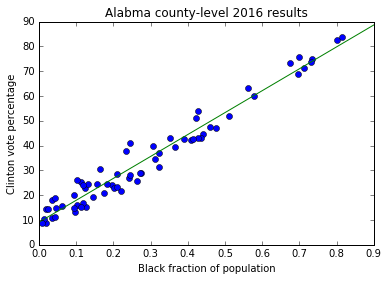

In [5]:
import matplotlib.pyplot as plt
plt.plot(Bpct, Cpct, 'o')
xax = np.arange(0,1,0.1)
plt.plot(xax, intercept + slope*xax)
plt.xlabel('Black fraction of population')
plt.ylabel('Clinton vote percentage')
plt.title('Alabma county-level 2016 results')

Yes, that is an excellent model.

### Does population matter?

If the residuals correlate with population, then it might be more complicated. For example, if white voters in big cities are more likely to vote for Clinton, then the total value of $W_C$ might have been underestimated (since there are, by definition, more voters there, so they should count more to the total).

First let's see if there's any correlation:

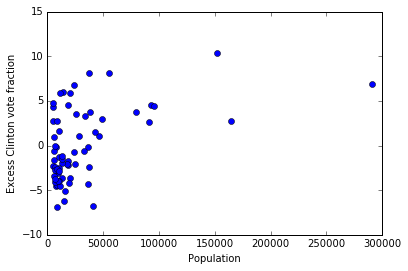

In [6]:
residual = Cpct - (intercept + slope*Bpct)
plt.plot(Pop, residual, 'o')
plt.xlabel('Population')
plt.ylabel('Excess Clinton vote fraction')

Yes, it appears that white voters in high-population counties voted for Clinton more than white voters in low-population counties. It also looks like a logarithmic scale for population would help.

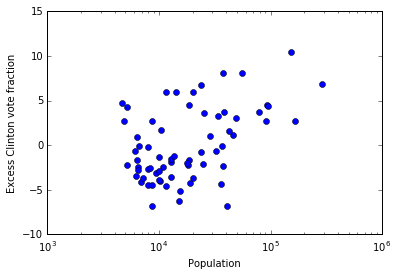

In [7]:
plt.semilogx(Pop, residual, 'o')
plt.xlabel('Population')
plt.ylabel('Excess Clinton vote fraction')

There's certainly a relationship, but it contains too much scatter to be worth fitting.

However, to get the total white Clinton vote share, I can simply use the residuals on their own. Given that the black Clinton vote share is already nearly 100%, I will assume that *all* of the population effect comes from the white voters. In other words, for a county with black population fraction $b$ and a Clinton vote share of $C$, I will assume that the Clinton white vote share is:

$$ W_C = a + r $$
where $a$ is the intercept from the original relationship (=9.1%) and $r \equiv C -(a + m b)$ is the residual.

Then I will add up all of the Clinton white votes and compare to the white population.

In [8]:
whitepop = Pop * (100. - Bpct) / 100.0
whiteCpct = intercept + residual
whiteCvotes = np.sum(whiteCpct/100.0 * whitepop)
whitevotes = np.sum(whitepop)
print 'White Clinton votes: ',whiteCvotes
print 'White votes: ',whitevotes
print 'White Clinton percentage: ', 100.0 * whiteCvotes / whitevotes


White Clinton votes:  242317.188045
White votes:  2034562.95634
White Clinton percentage:  11.9100363687


## Conclusion
About 12% of white voters in Alabama voted for Clinton, compared to about 97% of black voters.